In [1]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.7 MB/s eta 0:00:00


In [2]:
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.4 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/u

In [3]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399001 sha256=b12d7f9ab5ec8c3e5eeba4f54e7f99e47fc115b4643e1c9ad295f41d2f47c3dc
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [53]:
import stable_baselines3
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import base64
from pathlib import Path
from IPython import display as ipythondisplay

In [54]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_vec_env

In [55]:
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make("LunarLander-v3")
env = Monitor(env, log_dir)

eval_env = make_vec_env("LunarLander-v3", n_envs=1)

callback = EvalCallback(eval_env, best_model_save_path=log_dir, log_path=log_dir, eval_freq=15000, render=False, deterministic=True, n_eval_episodes=20)

model = PPO("MlpPolicy", "LunarLander-v3", verbose=0, tensorboard_log=os.path.join(log_dir, "tensorboard"))


In [56]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-304.86 +/- 58.74


In [57]:
model.learn(total_timesteps=300_000, callback=callback)
model.save("ppo_lunar")
#plot_results([log_dir], 1000, results_plotter.X_TIMESTEPS, "LunarLander-v3")
#plt.show()
del model

Eval num_timesteps=15000, episode_reward=-2649.28 +/- 1325.35
Episode length: 529.50 +/- 144.82
New best mean reward!
Eval num_timesteps=30000, episode_reward=-3388.24 +/- 1180.04
Episode length: 590.15 +/- 133.99
Eval num_timesteps=45000, episode_reward=-404.99 +/- 110.16
Episode length: 233.60 +/- 98.88
New best mean reward!
Eval num_timesteps=60000, episode_reward=-440.66 +/- 126.17
Episode length: 495.90 +/- 128.84
Eval num_timesteps=75000, episode_reward=-211.47 +/- 39.73
Episode length: 940.10 +/- 146.16
New best mean reward!
Eval num_timesteps=90000, episode_reward=-72.66 +/- 32.87
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=105000, episode_reward=-34.32 +/- 18.57
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=120000, episode_reward=-29.24 +/- 17.22
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=135000, episode_reward=-62.20 +/- 18.90
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=150000, ep

In [58]:
model = PPO.load("ppo_lunar")

mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:145.96 +/- 96.64


In [60]:
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [61]:
def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [62]:
def record_video(env_id, model, video_length=3000, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = make_vec_env("LunarLander-v3", n_envs=1, seed=0)
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [63]:
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

record_video("LunarLander-v3", best_model, video_length=3000, prefix="PPO-LunarLander")

Best Model - Mean reward: 125.78 +/- 111.83
Saving video to /content/videos/PPO-LunarLander-step-0-to-step-3000.mp4
Moviepy - Building video /content/videos/PPO-LunarLander-step-0-to-step-3000.mp4.
Moviepy - Writing video /content/videos/PPO-LunarLander-step-0-to-step-3000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/PPO-LunarLander-step-0-to-step-3000.mp4


In [64]:
show_videos("videos", prefix="PPO")

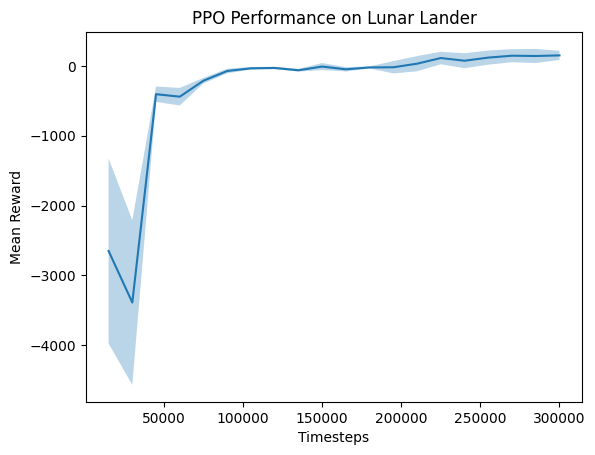

In [65]:
from IPython.core.prefilter import PrefilterHandler
# Load the evaluations.npz file
data = np.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = np.mean(results, axis=1)
std_results = np.std(results, axis=1)

# Plot the results
plt.figure()
plt.plot(timesteps, mean_results)
plt.fill_between(timesteps,mean_results - std_results,mean_results + std_results,alpha=0.3)

plt.xlabel('Timesteps')
plt.ylabel('Mean Reward')
plt.title("PPO Performance on Lunar Lander")
plt.savefig(os.path.join(log_dir, "PPO_Lunar_Lander_performance.png"))
plt.show()